# CSI 4810 - Project 2 - Text Mining Reddit Posts
##### Willow Connelly

---


In [ ]:
import praw
import spacy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from spacy import displacy
from wordcloud import WordCloud
from collections import Counter

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

pd.set_option('display.max_colwidth', None)

---
### Read-in Data

In [ ]:
reddit = praw.Reddit(
    client_id="5DEFxmbu1nIVbteepOjXdw",
    client_secret="phSKbMc45hNevM3m-u8U5opnCg3pcg",
    user_agent="CSI4810_p2 version 1 by /u/Worldly_Turnip1077",
)

print(reddit.read_only)
data = []
for submission in reddit.subreddit("politics").top(limit=500,time_filter="month"):
    data.append(submission)
    # print(submission.title)

with open("reddit_submissions.pkl", "wb") as f:
    pickle.dump(data, f)

In [ ]:
# read in already collected data so you don't have to call API again
with open("reddit_submissions.pkl", "rb") as f:
    data = pickle.load(f)

---
### Preprocessing

handling case

In [ ]:
titles, ogTitles = []
for d in data:
    ogTitles.append(d.title)
    titles.append(d.title.lower())

nlp

In [333]:
nlp = spacy.load('en_core_web_sm')
docs = list(nlp.pipe(titles))

NER


As we can see, the NER from spacy is all over the place. It is highly inaccurate given the original data's capitalization and formatting. It was tested with original data format and data converted to lowercase. Both yield terrible results. Thankfully, the NER is not necessary for topic detection and other methods will be employed instead, namely POS tagging

In [ ]:
# with original case
displacy.render(list(nlp.pipe(ogTitles))[:10], style='ent', jupyter=True)

c:\Users\willo_jlqcl0r\miniconda3\envs\textMining\Lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [335]:
# with lowercase
displacy.render(docs[:10], style='ent' )

---

Stop word removal, lemmatizing, and non word removal

In [339]:
words_to_exclude = {"sanders"}
my_stop_words = {'say'}
cleaned_docs = []

for doc in docs:
    l = []
    for token in doc:
        if (token.is_alpha and not token.is_stop and token.lemma_ not in my_stop_words):
            l.append(token.lemma_ if token.text not in words_to_exclude else token.text)
    cleaned_docs.append(l)

cleaned_docs = [' '.join(tokens) for tokens in cleaned_docs]
cleaned_docs[:10]

['sen bernie sanders win fourth term represent vermont',
 'arnold schwarzenegg endorse kamala harris recognize country',
 'jeff bezos kill washington post endorsement kamala harris paper report',
 'high school student witness fight release damn house ethic report allegation matt gaetz donald trump pick attorney general sex year old girl begin',
 'time hold democratic party elite responsible catastrophe',
 'elon musk ai turn label significant spreader misinformation x',
 'sanders democratic party abandon work class people',
 'kamala harris ask americans go elect guy good thing hitler',
 'texas teen suffering miscarriage die day baby shower abortion ban mom beg doctor',
 'texas woman die hospital crime intervene miscarriage']

---

### Term frequency

In [ ]:
vectorizer = CountVectorizer(stop_words='english',binary=False).fit(cleaned_docs) 

transformed = vectorizer.transform(cleaned_docs).toarray()
word_freq = pd.DataFrame(transformed.sum(axis=0).reshape(1,len(vectorizer.vocabulary_)),
                         columns=vectorizer.get_feature_names_out())

print(f"Number of terms selected: {len(vectorizer.vocabulary_)}\n")
print("Most frequent words:\n", word_freq.iloc[0].nlargest(5))

Number of terms selected: 1526

Most frequent words:
 trump       301
harris      107
donald       60
kamala       59
election     47
Name: 0, dtype: int64


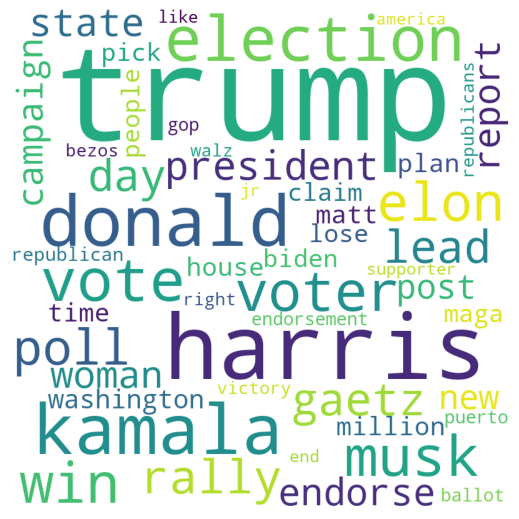

In [341]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(word_freq.iloc[0].nlargest(50).to_dict())

plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

---

Topic sentence detection Util Functions

In [390]:
def createDataStruct(clusterNumber):
    ds = {}
    for i in range(clusterNumber):
        ds[i] = {'verb':[],
                 'subj': [],
                 'obj':[],
                 'topic':[]}
    return ds

def extractTopics(clusterNumber,docClusterList):
    topicList = createDataStruct(clusterNumber)
    
    for i,doc in enumerate(docs):
        cluster = docClusterList[i]
        if cluster == -1: continue
        for token in doc:
            if(token.is_alpha and not token.is_stop and token.lemma_ not in my_stop_words):
                if(token.dep_ == 'nsubj'):
                    topicList[cluster]['subj'].append(token.lemma_ if token not in words_to_exclude else token.text)
                if(token.dep_ == 'ROOT'):
                    topicList[cluster]['verb'].append(token.lemma_)
                if(token.dep_ == 'dobj'):
                    topicList[cluster]['obj'].append(token.lemma_ if token not in words_to_exclude else token.text)

    for key,val in topicList.items():
        val['topic'].extend([Counter(val['subj']).most_common(1)[0][0],
                             Counter(val['verb']).most_common(1)[0][0],
                             Counter(val['obj']).most_common(2)[0][0],
                             Counter(val['obj']).most_common(2)[1][0]
                             ])
    return topicList

---
### Topic Detection - tf-idf NMF

In [ ]:
tvect = TfidfVectorizer(stop_words='english')
tfidf = tvect.fit_transform(cleaned_docs)

w (500, 20) 
h (20, 1526)


In [ ]:
nmf = NMF(beta_loss="kullback-leibler",solver="mu",n_components=20)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("w",W.shape,"\nh",H.shape)

In [450]:
ws = tvect.get_feature_names_out()

topwords=[]
for i,topic in enumerate(H):
    topwords.append(pd.DataFrame(H, columns = ws).iloc[i].nlargest(10).index)

topdoc=[]
for doc in enumerate(W):
    topdoc.append(doc[1].argmax())
topwords = pd.DataFrame([' '.join(tokens) for tokens in topwords],columns=['topic_top_words'])
topwords

,topic_top_words
0,harris kamala poll endorse trump lead final donald iowa deserve
1,donald trump look elon musk make piss confession shocking away
2,musk elon million lottery pac voter putin philadelphia vladimir misinformation
3,washington post endorsement bezos editor jeff democracy kill paper owner
4,gaetz report matt ethic release general attorney pick ag nomination
5,year vote gabbard gaetz john congress old tulsi oliver election
6,election suddenly win trump think day presidential poll supreme voter
7,vote lead new point poll trump man maga husband woman
8,win state senate carolina north democrat economy race republican democrats
9,rally puerto rico trump support garden madison square ricans joke


In [451]:
tfidfTopics = extractTopics(W.shape[1],topdoc)
tfidfTopics = pd.concat([pd.DataFrame([(x,y['topic']) for x,y in tfidfTopics.items()],
                                      columns=['topic_number','topic_desc']), 
                                      topwords], axis=1)
tfidfTopics

,topic_number,topic_desc,topic_top_words
0,0,"[harris, show, trump, harris]",harris kamala poll endorse trump lead final donald iowa deserve
1,1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away
2,2,"[musk, sue, musk, lottery]",musk elon million lottery pac voter putin philadelphia vladimir misinformation
3,3,"[bezos, quit, endorsement, post]",washington post endorsement bezos editor jeff democracy kill paper owner
4,4,"[gaetz, begin, report, sex]",gaetz report matt ethic release general attorney pick ag nomination
5,5,"[harris, call, ballot, election]",year vote gabbard gaetz john congress old tulsi oliver election
6,6,"[trump, trump, election, win]",election suddenly win trump think day presidential poll supreme voter
7,7,"[woman, vote, vote, lead]",vote lead new point poll trump man maga husband woman
8,8,"[harris, win, term, race]",win state senate carolina north democrat economy race republican democrats
9,9,"[trump, spread, rally, harris]",rally puerto rico trump support garden madison square ricans joke


In [452]:
topicDocMatrix = pd.concat([pd.DataFrame(titles,columns=["title"]),pd.DataFrame(topdoc,columns=["topic_number"])],
                           axis=1).join(tfidfTopics[['topic_desc','topic_top_words']], on='topic_number')
topicDocMatrix.drop('topic_top_words',axis=1)

,title,topic_number,topic_desc
0,sen. bernie sanders wins a fourth term representing vermont,8,"[harris, win, term, race]"
1,arnold schwarzenegger endorses kamala harris: 'don't recognize our country',2,"[musk, sue, musk, lottery]"
2,"jeff bezos killed washington post endorsement of kamala harris, paper reports",3,"[bezos, quit, endorsement, post]"
3,“she was a high school student and there were witnesses.” - the fight to release a damning house ethics report about allegations that matt gaetz—donald trump’s pick for attorney general—had sex with a 17-year-old girl has begun.,4,"[gaetz, begin, report, sex]"
4,this time we have to hold the democratic party elite responsible for this catastrophe,17,"[trump, tell, trump, harris]"
...,...,...,...
495,president biden names fifty-sixth round of judicial nominees,14,"[trump, endorse, harris, control]"
496,fallout from florida latinos fierce following racist jokes during former president’s nyc rally,9,"[trump, spread, rally, harris]"
497,"harris expands her lead over trump to 10 points in virginia, new roanoke college poll says",7,"[woman, vote, vote, lead]"
498,donald trump is already looking to gut medicaid: republicans are looking to cut federal assistance programs in order to extend trump's 2017 corporate tax cut.,11,"[trump, trump, pick, plan]"


In [459]:
topicDocMatrix[topicDocMatrix['topic_number'] == 1]

,title,topic_number,topic_desc,topic_top_words
53,donald trump got away with everything,1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away
64,trump makes chilling joke about staying in power forever - donald trump isn’t so sure about the two-term limit.,1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away
102,aileen cannon being considered as donald trump's ag sparks fury: 'insane',1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away
145,elon musk is pissing off everyone on trump’s team,1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away
149,elon musk makes shocking confession on his plans after trump victory,1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away
157,"charlamagne tha god slams cnn for ""bullshit"" trump coverage",1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away
169,trump snaps at reporter when asked about abortion: 'stop talking about it',1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away
208,trump doubles down after elon’s shocking “tank the economy” confession,1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away
210,"trump announces elon musk, vivek ramaswamy to lead new ‘department of government efficiency’",1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away
259,"donald trump jokes he 'can't get rid' of elon musk amid growing influence | ""elon won't go home. i can't get rid of him—at least until i don't like him,"" trump joked, acknowledging musk's growing presence.",1,"[trump, make, trump, fury]",donald trump look elon musk make piss confession shocking away


---